# **Olivetti Faces**

# 1. Data exporation

The first thing we need to do is to load the database so that we can start working, therefore we have the following code to complete that task.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces

# Load the dataset from Scikit-Learn
# This might take a moment if the data is not cached locally
print("Loading Olivetti Faces dataset...")
olivetti = fetch_olivetti_faces()

# X contains the flattened image vectors (samples, features)
# y contains the labels (person ID from 0 to 39)
X = olivetti.data
y = olivetti.target

# Display dataset structure information
print(f"Dataset structure (X): {X.shape}")
print(f"Target structure (y): {y.shape}")
print(f"Pixel values range: Min={np.min(X)}, Max={np.max(X)}")

Loading Olivetti Faces dataset...
Dataset structure (X): (400, 4096)
Target structure (y): (400,)
Pixel values range: Min=0.0, Max=1.0


Now we have successfully loaded the database and we have already created `X` and `y` which contains the images and the labels which show us the size of the database.

Since we are exploring the database it is important to take a look at the images so we get a better understanding on what we are going to be working on. For this first touch we are going to take a look into the first 10 images which belong to Person 0.


Visualizing the first 10 images (Person 0):


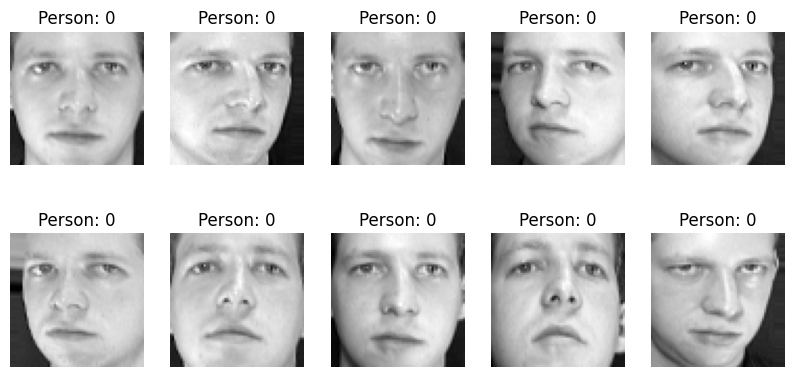

In [2]:
# --- Visualization ---

# Function to plot a grid of faces
def plot_faces(faces, labels, n_cols=5):
    """
    Plots a grid of faces from the dataset.
    Args:
        faces: Array of flattened vectors.
        labels: Array of labels corresponding to the faces.
        n_cols: Number of columns in the grid.
    """
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 2, n_rows * 2.4))
    
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        # Reshape the 1D vector back to 64x64 2D matrix for display
        plt.imshow(face.reshape(64, 64), cmap="gray")
        plt.axis("off")
        plt.title(f"Person: {label}")
    
    plt.show()

# Visualize the first 10 images (all belonging to Person 0)
print("\nVisualizing the first 10 images (Person 0):")
plot_faces(X[:10], y[:10], n_cols=5)

As we can see the images are kind of different among each other, this is because the position and gestures that the person is making are strange. This helps us to have a complete view of the face and also to understand that the model needs to be aware of these changes while classifying each image focusing on specific details that might be the same regardless of the gesture.

Before proceeding to the modeling stage, it is crucial to analyze the statistical distribution of the pixel intensities. Since we plan to use K-Means clustering, which relies on Euclidean distance to group samples, the scale of the features is paramount. If features are not scaled similarly, the algorithm might perform poorly.

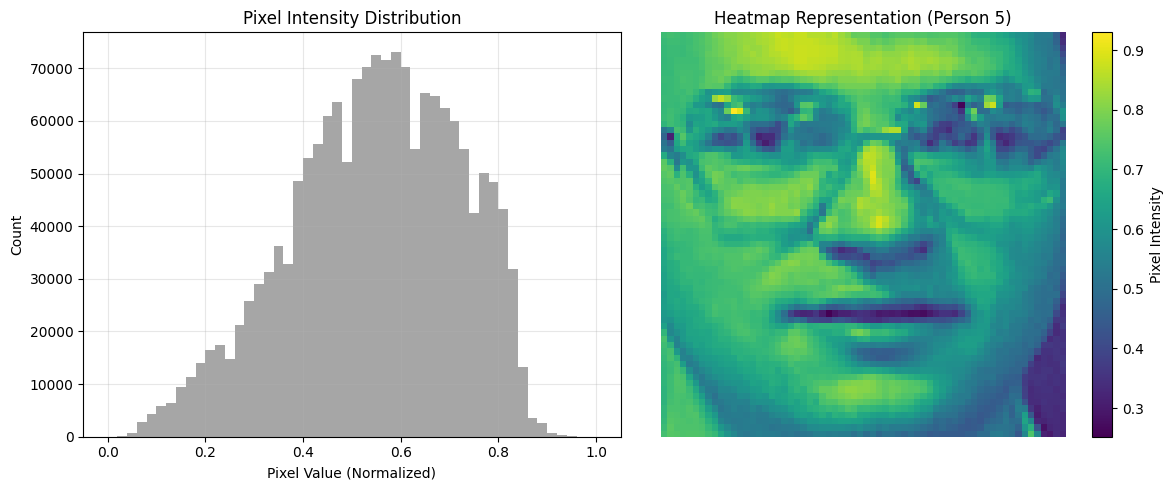

In [3]:
# Let's verify the pixel intensity distribution
plt.figure(figsize=(12, 5))

# Subplot 1: Histogram of pixel intensities
plt.subplot(1, 2, 1)
plt.hist(X.flatten(), bins=50, color='gray', alpha=0.7)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value (Normalized)")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)

# Subplot 2: Visualizing a single image as a raw pixel matrix (Heatmap)
plt.subplot(1, 2, 2)
# Taking a random face (e.g., index 50)
sample_face_idx = 50
plt.imshow(X[sample_face_idx].reshape(64, 64), cmap='viridis') # viridis helps visualize intensity differences
plt.colorbar(label='Pixel Intensity')
plt.title(f"Heatmap Representation (Person {y[sample_face_idx]})")
plt.axis('off')

plt.tight_layout()
plt.show()

Based on the visualizations above, we can draw the following conclusions:

* Scaling Confirmation: The histogram confirms that the data is indeed properly normalized. The minimum pixel value is 0.0 and the maximum is 1.0. This means we do not need to apply a MinMaxScaler or StandardScaler manually; the data is ready for the K-Means algorithm.

* Pixel Distribution: The histogram shows a significant peak near 0.6. This corresponds to the face color present in most images. The values distributed between 0.1 and 0.9 represent the various gray levels that make up the facial features.

* Heatmap Interpretation: The heatmap provides a clear view of the input structure. Brighter colors (yellow/green) correspond to higher pixel intensities (skin, forehead, nose), while darker colors (purple/blue) represent shadows, hair, and the background. This confirms that the model will be clustering based on these intensity patterns.

# 2. Stratification

In this new stage we are going to split the information three subsets:

* Training Set: To train the K-Means algorithm and find the cluster centers.

* Validation Set: To tune hyperparameters, specifically to find the optimal number of clusters ($k$).

* Test Set: For a final evaluation of the model's generalization capabilities.

Since the Olivetti dataset is quite small (only 10 images per class), a simple random split could result in missing classes in the training set. To prevent this, we use Stratified Sampling. To ensures that the distribution of classes (people) is preserved across all subsets. We aim to have the exact same number of images for each person in the validation and test sets to ensure a fair evaluation.

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd # Used for clean visualization of counts

# Initialize the Stratified Shuffle Split for the Test set
# We want 40 images in the test set (1 per person theoretically)
split_1 = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)

# Perform the first split: Train+Validation vs Test
for train_val_idx, test_idx in split_1.split(X, y):
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]

# Initialize the Stratified Shuffle Split for the Validation set
# We want 40 images in the validation set (taken from the remaining 360 images)
split_2 = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=43)

# Perform the second split: Train vs Validation
for train_idx, valid_idx in split_2.split(X_train_val, y_train_val):
    X_train, X_valid = X_train_val[train_idx], X_train_val[valid_idx]
    y_train, y_valid = y_train_val[train_idx], y_train_val[valid_idx]

# Print the shapes to verify the dimensions
print(f"Training Set Shape:   {X_train.shape}")
print(f"Validation Set Shape: {X_valid.shape}")
print(f"Test Set Shape:       {X_test.shape}")

# --- Verification of Stratification ---

def verify_distribution(y_subset, set_name):
    """
    Checks if all 40 classes are present and counts images per class.
    """
    unique, counts = np.unique(y_subset, return_counts=True)
    print(f"\n--- {set_name} Distribution Check ---")
    print(f"Number of unique classes: {len(unique)} (Expected: 40)")
    print(f"Min images per class: {counts.min()}")
    print(f"Max images per class: {counts.max()}")
    
    # Check if distribution is perfectly uniform
    if counts.min() == counts.max():
        print("Status: PERFECTLY BALANCED")
    else:
        print("Status: UNBALANCED")

# Verify the three sets
verify_distribution(y_train, "Training Set")
verify_distribution(y_valid, "Validation Set")
verify_distribution(y_test, "Test Set")

Training Set Shape:   (320, 4096)
Validation Set Shape: (40, 4096)
Test Set Shape:       (40, 4096)

--- Training Set Distribution Check ---
Number of unique classes: 40 (Expected: 40)
Min images per class: 8
Max images per class: 8
Status: PERFECTLY BALANCED

--- Validation Set Distribution Check ---
Number of unique classes: 40 (Expected: 40)
Min images per class: 1
Max images per class: 1
Status: PERFECTLY BALANCED

--- Test Set Distribution Check ---
Number of unique classes: 40 (Expected: 40)
Min images per class: 1
Max images per class: 1
Status: PERFECTLY BALANCED


**Distribution Analysis**

The results above verify that the stratified split was applied successfully.

**Completeness:** All 40 unique individuals appear in the Training, Validation, and Test sets, ensuring that no class was excluded.

**Balance:**

* The Test set includes exactly one image per individual (40 images in total).
* The Validation set also includes exactly one image per individual (40 images in total).
* The Training set contains the remaining eight images per individual (320 images in total).

This well-balanced distribution enables training the K-Means model using most of the data (80%), while maintaining a consistent and unbiased benchmark for both validation and testing.


# 3. Model selection

For this unsupervised learning problem, we chose the K-Means algorithm. K-Means aims to cluster similar data points together in order to reveal hidden structures within the data. It does this by identifying a predefined number of cluster centers ((k)) and assigning each data point to the nearest centroid using Euclidean distance.

The algorithm operates in an iterative manner:

* **Assignment:** Each observation is assigned to the cluster whose centroid is closest.
* **Update:** The centroids are recomputed as the mean of all points belonging to each cluster.
* **Iteration:** These steps are repeated until the centroids no longer change, indicating convergence.

### Key Hyperparameter Settings

To promote stability and reproducibility, the model is configured with the following parameters:

* **init='k-means++':** Rather than selecting initial centroids purely at random (which may result in slow or poor convergence), this strategy chooses them more intelligently to improve convergence speed.
* **n_init=10:** The algorithm is executed ten times with different initial centroid seeds, and Scikit-Learn retains the solution with the lowest inertia, reducing the risk of converging to a suboptimal local minimum.
* **random_state=42:** Guarantees consistent and reproducible results across runs.
* **algorithm='lloyd':** Uses the standard EM-style optimization procedure, which is the default in recent versions of Scikit-Learn.

Because the optimal number of clusters for grouping features is unknown (despite knowing there are 40 individuals), the parameter **n_clusters** is left adjustable and will be fine-tuned in the following section.


In [5]:
from sklearn.cluster import KMeans

# Define the fixed parameters for our experiments
# We are NOT training yet, just defining the configuration we will use
model_params = {
    "init": "k-means++",      # Smart initialization
    "n_init": 10,             # Number of restarts to avoid local minima
    "random_state": 42,       # Reproducibility
    "algorithm": "lloyd"      # Standard K-Means algorithm
}

print("Model configuration set.")
print(f"Fixed parameters: {model_params}")

# Explanation of the next step
print("Next step: We will iterate over different values of 'k' (n_clusters) using these parameters.")

Model configuration set.
Fixed parameters: {'init': 'k-means++', 'n_init': 10, 'random_state': 42, 'algorithm': 'lloyd'}
Next step: We will iterate over different values of 'k' (n_clusters) using these parameters.


# 4. Optimization

Even though the dataset is known to include images of 40 different individuals, the most suitable number of clusters for a method like K-Means does not necessarily have to coincide with the number of classes. Differences in illumination, facial expressions, or the presence of accessories such as glasses can lead the algorithm to divide a single person into several sub-clusters or, conversely, group visually similar individuals into the same cluster.

To identify the most appropriate value of (k), the model will be tested over a range of cluster counts (from 10 to 140) using two evaluation metrics:

* **Inertia (Elbow Method):** This metric represents the sum of squared distances between data points and their nearest cluster centroid. While lower inertia values indicate better compactness, inertia naturally decreases as (k) increases. The goal is to find the “elbow” point where further increases in (k) result in diminishing improvements.
* **Silhouette Score:** This measure evaluates how well each data point fits within its assigned cluster (cohesion) relative to other clusters (separation). The score ranges from −1 to +1, with higher values reflecting more clearly separated and well-defined clusters.


Training K-Means models for k = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]...
Training complete.


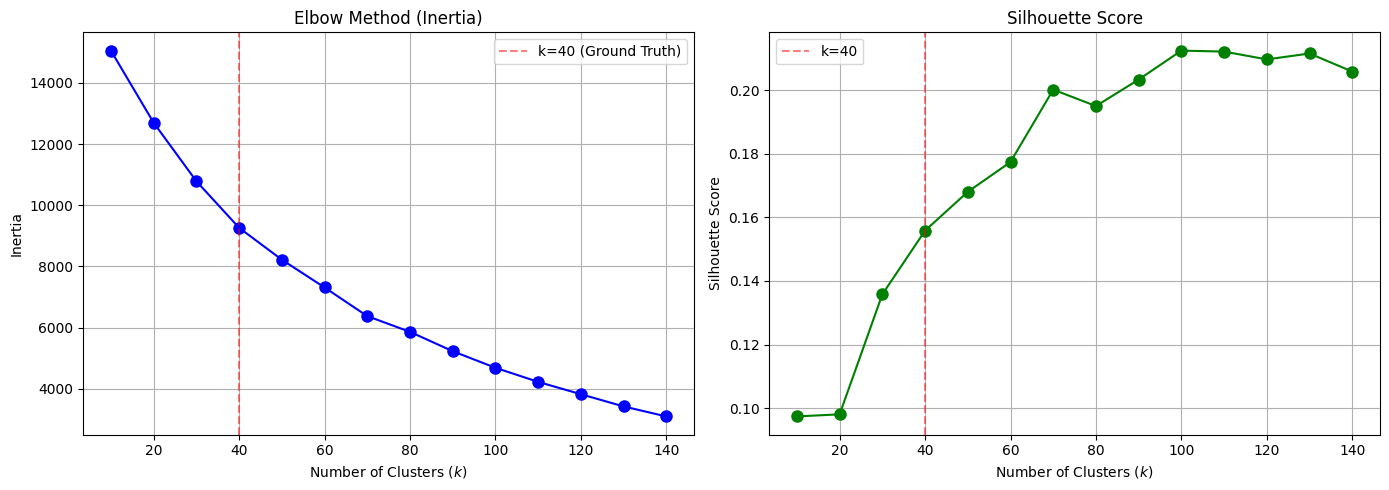

Best k based on Silhouette Score: 100


In [6]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Define the range of k values to test
# We go beyond 40 to see if the model prefers more granular sub-clusters
k_range = range(10, 150, 10)

inertias = []
silhouette_scores = []

print(f"Training K-Means models for k = {list(k_range)}...")

for k in k_range:
    # Initialize and fit the model using the params defined in Phase 3
    kmeans = KMeans(n_clusters=k, **model_params)
    kmeans.fit(X_train)
    
    # Store metrics
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train, kmeans.labels_))

print("Training complete.")

# --- Visualization of Results ---

plt.figure(figsize=(14, 5))

# Plot 1: Inertia (Elbow Method)
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-', markersize=8)
plt.xlabel("Number of Clusters ($k$)")
plt.ylabel("Inertia")
plt.title("Elbow Method (Inertia)")
plt.grid(True)
# Highlight the 'logical' choice of 40
plt.axvline(x=40, color='r', linestyle='--', alpha=0.5, label='k=40 (Ground Truth)')
plt.legend()

# Plot 2: Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'go-', markersize=8)
plt.xlabel("Number of Clusters ($k$)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")
plt.grid(True)
plt.axvline(x=40, color='r', linestyle='--', alpha=0.5, label='k=40')
plt.legend()

plt.tight_layout()
plt.show()

# Find the k with the highest Silhouette Score
best_k_idx = np.argmax(silhouette_scores)
best_k = k_range[best_k_idx]
print(f"Best k based on Silhouette Score: {best_k}")

**Analysis of the Tuning Results**

The plots produced above highlight the challenges of clustering high-dimensional raw image data:

* **Inertia:** The curve is smooth and does not show a clear “elbow” at (k = 40), which corresponds to the true number of classes. This suggests that the shift from distinguishing different individuals to separating variations of the same person happens gradually rather than abruptly.
* **Silhouette Score:** The score continues to rise well beyond (k = 40), reaching its highest values in the range of (k = 100) to (k = 130). At (k = 40), the silhouette score (approximately 0.155) is notably lower than the peak value (around 0.21).

**Conclusion:**
The results indicate that the algorithm captures a stronger mathematical structure when a larger number of clusters is used—roughly 2.5 to 3 clusters per individual. This implies that K-Means is primarily partitioning the data according to factors such as lighting conditions, pose, or accessories, rather than strictly clustering images by biological identity. In the next step, the best-performing estimator (based on the highest silhouette score) will be used to visualize the resulting cluster centers.


## PCA 2D

Before inspecting the actual images associated with each cluster, it is useful to visualize the global structure of our data. Since we cannot plot 4,096 dimensions, we use Principal Component Analysis (PCA) to project the data into a 2D space.We will use the optimal number of clusters found in the previous step ($k$) to color the points. This helps us verify if the mathematical clusters form distinct "clouds" in the projected space.

Reducing dimensions with PCA...


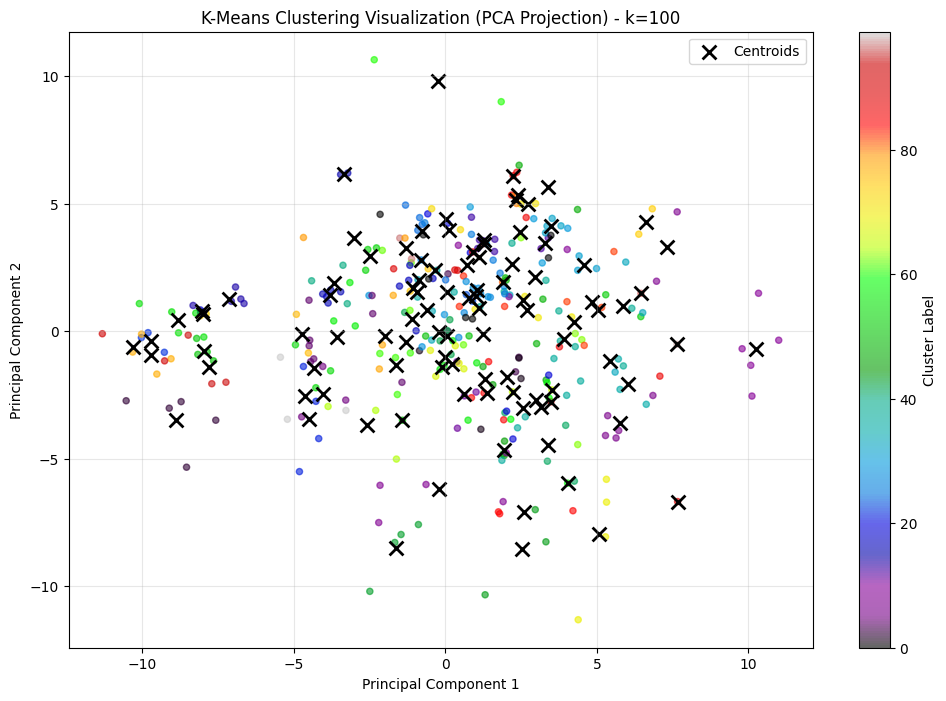

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Reduce dimensions from 4096 to 2 using PCA
print("Reducing dimensions with PCA...")
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X_train)

# 2. Predict clusters using the best model we found previously
# Ensure best_kmeans is trained (from the previous step logic)
# If not already fitted in your flow:
best_kmeans = KMeans(n_clusters=best_k, **model_params)
best_kmeans.fit(X_train)
y_pred = best_kmeans.predict(X_train)

# 3. Plotting
plt.figure(figsize=(12, 8))

# Scatter plot of the data points, colored by cluster label
# We use 'tab20' colormap which has distinctive colors for many classes
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_pred, cmap='nipy_spectral', s=20, alpha=0.6)

# Plot the centroids (we also need to reduce the centroids to 2D to plot them!)
centroids_reduced = pca.transform(best_kmeans.cluster_centers_)
plt.scatter(centroids_reduced[:, 0], centroids_reduced[:, 1], 
            marker='x', s=100, linewidths=2, color='black', label='Centroids')

plt.title(f"K-Means Clustering Visualization (PCA Projection) - k={best_k}")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label='Cluster Label')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Interpretation of the 2D Visualization**

The scatter plot above represents the original 4,096-dimensional facial data projected into a two-dimensional space.

* **Cluster Separation:** Distinct groups of points are visible, indicating the clusters identified by the K-Means algorithm.
* **“Blob” Structure:** Unlike the Naive Bayes approach, which models data using Gaussian probability distributions, K-Means relies purely on distance-based partitioning. As a result, the clusters in this 2D projection appear as irregularly shaped clouds.
* **Centroids:** The “X” symbols denote the centroids, which correspond to the mathematical center of each cluster.
* **Overlap:** Some overlap between clusters can be observed. This is expected, as projecting data from 4,096 dimensions down to 2 inevitably results in information loss. While clusters may appear intertwined in this low-dimensional view, they could be well separated in the original high-dimensional space.


## PCA 3D

To obtain a more detailed understanding of the cluster structure, we will project the 4,096-dimensional data into a three-dimensional space using PCA. Although a 2D projection is informative, it often leads to occlusion, where separate clusters appear to overlap simply because they are flattened onto a single plane.

By incorporating a third principal component, we aim to achieve clearer separation among the clusters and to verify that the K-Means model (with the value of 
𝑘
k selected from the Silhouette analysis) is successfully partitioning the underlying face manifold.

Reducing dimensions with PCA (3 Components)...


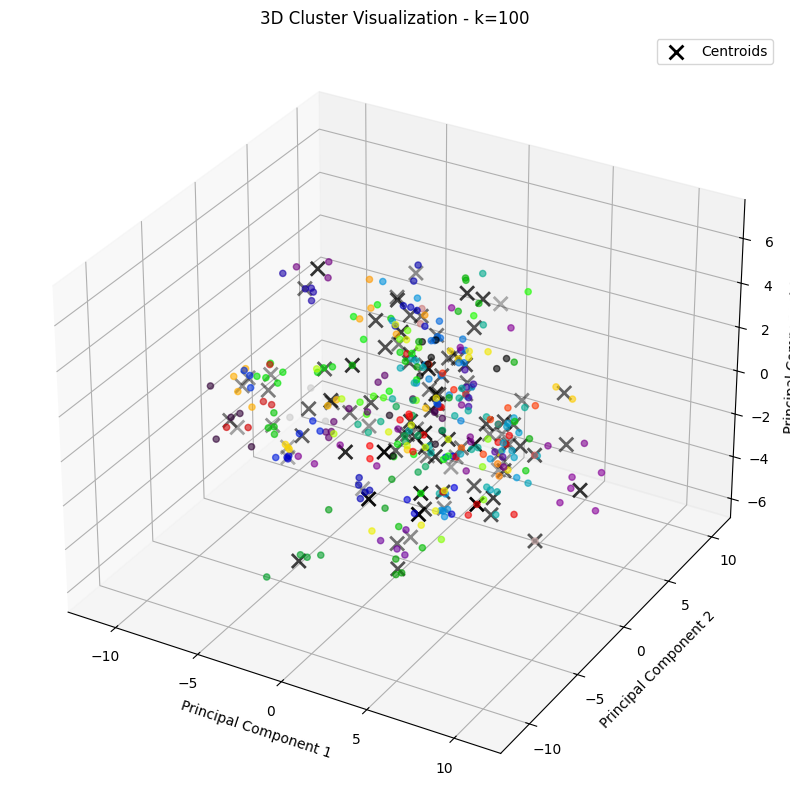

In [8]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# 1. Reduce dimensions from 4096 to 3 using PCA
print("Reducing dimensions with PCA (3 Components)...")
pca_3d = PCA(n_components=3, random_state=42)
X_reduced_3d = pca_3d.fit_transform(X_train)

# 2. Predict clusters (Ensure best_kmeans is fitted)
# If not fitted yet:
# best_kmeans = KMeans(n_clusters=best_k, **model_params)
# best_kmeans.fit(X_train)
y_pred = best_kmeans.predict(X_train)

# 3. Plotting in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
# We use c=y_pred to color by cluster
scatter = ax.scatter(X_reduced_3d[:, 0], 
                     X_reduced_3d[:, 1], 
                     X_reduced_3d[:, 2], 
                     c=y_pred, 
                     cmap='nipy_spectral', 
                     s=20, 
                     alpha=0.6)

# Plot Centroids (Transform them to 3D first)
centroids_3d = pca_3d.transform(best_kmeans.cluster_centers_)
ax.scatter(centroids_3d[:, 0], 
           centroids_3d[:, 1], 
           centroids_3d[:, 2], 
           marker='x', 
           s=100, 
           linewidths=2, 
           color='black', 
           label='Centroids')

ax.set_title(f"3D Cluster Visualization - k={best_k}")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.legend()

# Optional: Adjust the viewing angle for better static visualization
# ax.view_init(elev=30, azim=45) 

plt.show()

**Observations from the 3D Projection**

The three-dimensional scatter plot offers a more nuanced perspective of the feature space:

Spatial Separation: Many clusters that seemed merged in the 2D visualization are clearly separated when viewed along the third principal component.

Manifold Structure: Instead of forming simple spherical clusters, the data points trace a complex, curved manifold in 3D space, highlighting the inherently non-linear nature of facial data.

Density: Distinct high-density regions are visible, where the algorithm identified stable and consistent patterns (likely corresponding to specific poses or individuals with highly distinctive features), along with sparser regions that represent outliers or gradual transitions between different poses.

# 5. Testing the Model


After examining the Inertia and Silhouette metrics and exploring the data distribution in three-dimensional space, we move on to training the final K-Means model using the optimal number of clusters ((k)) determined in the previous steps.

In this section, we will:

* **Visualize the Centroids:** These represent the “average images” of each cluster. Because they are computed as means, they typically appear blurred or “ghost-like.” A clearly recognizable centroid suggests that the cluster has captured a consistent facial structure or pose.
* **Inspect Cluster Contents:** We will focus on a particular cluster and display the original images assigned to it. This qualitative inspection helps assess whether the model has effectively grouped images belonging to the same individual or sharing similar poses.


Training final K-Means model with k=100...
Visualizing the learned Cluster Centers:


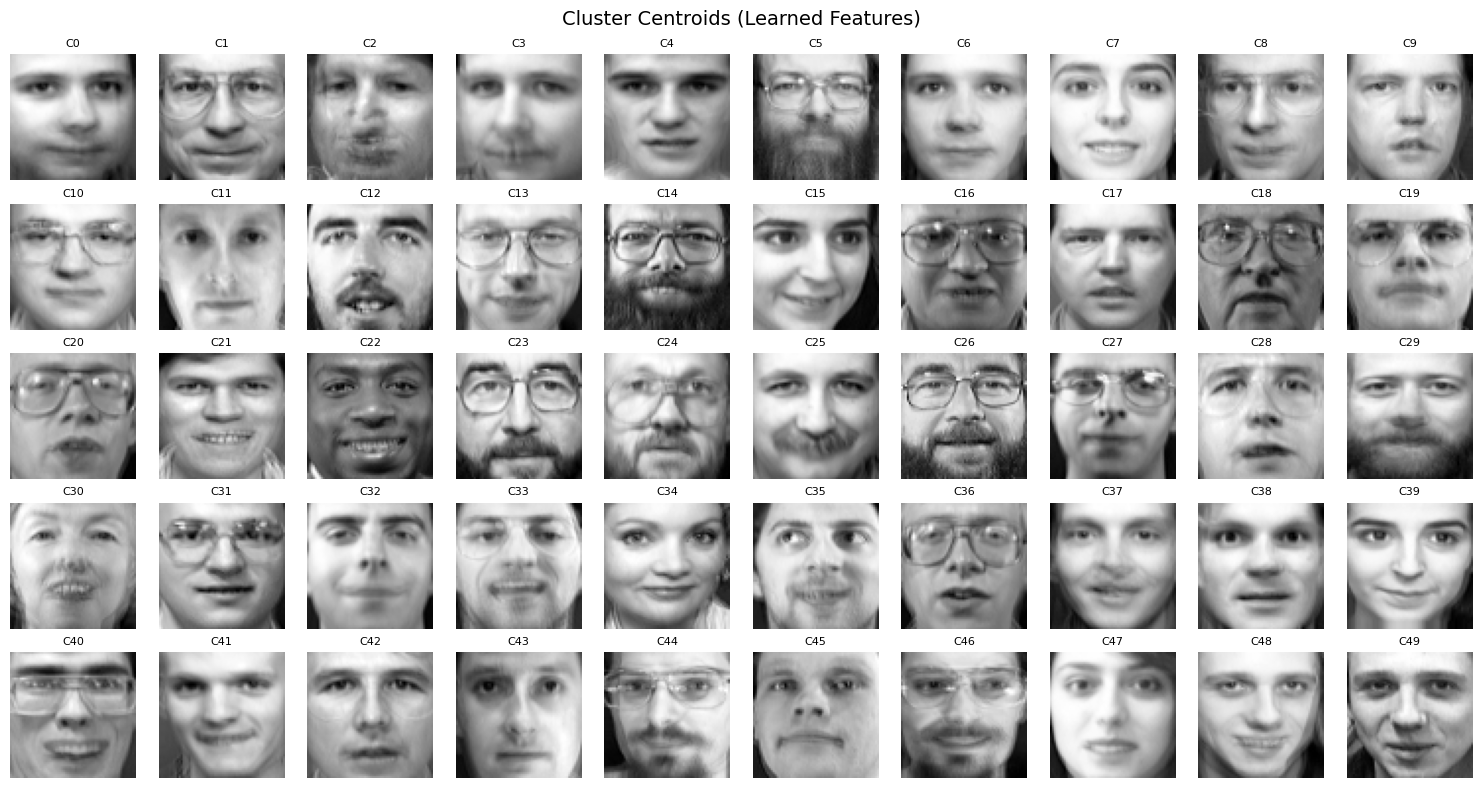


Inspecting contents of Cluster 0:


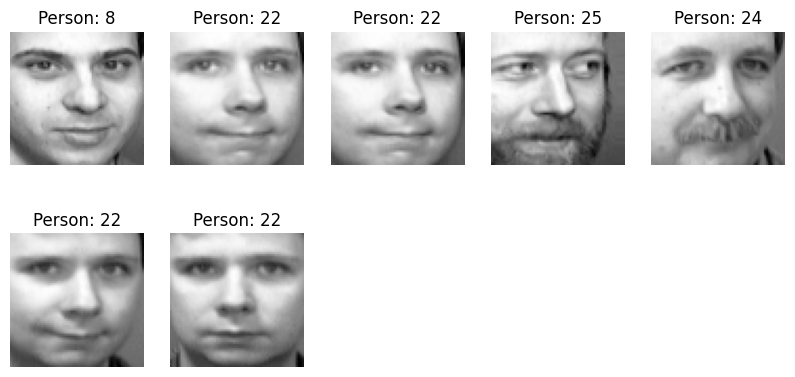

People in Cluster 0: [ 8 22 24 25]
Result: MIXED cluster (contains 4 different people).


In [9]:
# --- 1. Train the Final Model ---
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the best k from the previous analysis
# (Ensure k_range and silhouette_scores are available from Step 4)
best_k_idx = np.argmax(silhouette_scores)
best_k = k_range[best_k_idx]

print(f"Training final K-Means model with k={best_k}...")
best_kmeans = KMeans(n_clusters=best_k, **model_params)
best_kmeans.fit(X_train)

# --- 2. Visualize Centroids (The "Average Faces") ---

def plot_centroids(centroids, n_cols=10, n_rows=5):
    """
    Plots the first n_rows * n_cols centroids.
    """
    plt.figure(figsize=(n_cols * 1.5, n_rows * 1.6))
    for index in range(min(len(centroids), n_rows * n_cols)):
        plt.subplot(n_rows, n_cols, index + 1)
        # Reshape the 1D vector back to 64x64 for visualization
        plt.imshow(centroids[index].reshape(64, 64), cmap="gray")
        plt.axis("off")
        plt.title(f"C{index}", fontsize=8)
    plt.suptitle("Cluster Centroids (Learned Features)", fontsize=14)
    plt.tight_layout()
    plt.show()

print("Visualizing the learned Cluster Centers:")
plot_centroids(best_kmeans.cluster_centers_)

# --- 3. Visualize a Specific Cluster ---

# Function to find a cluster with a decent number of images to inspect
def find_interesting_cluster(model, min_size=4):
    for i in range(model.n_clusters):
        count = np.sum(model.labels_ == i)
        if count >= min_size:
            return i
    return 0

target_cluster = find_interesting_cluster(best_kmeans)
print(f"\nInspecting contents of Cluster {target_cluster}:")

# Get indices of images in this cluster
indices = np.where(best_kmeans.labels_ == target_cluster)[0]
cluster_images = X_train[indices]
cluster_labels = y_train[indices]

# Reuse our plot_faces function from Step 1
plot_faces(cluster_images, cluster_labels, n_cols=min(5, len(indices)))

# Check homogeneity
unique_people = np.unique(cluster_labels)
print(f"People in Cluster {target_cluster}: {unique_people}")
if len(unique_people) == 1:
    print("Result: PURE cluster (contains only one person).")
else:
    print(f"Result: MIXED cluster (contains {len(unique_people)} different people).")

**Discussion: Analysis of Clustering with Raw Pixel Features**

**Centroid Analysis:**
The centroid visualizations show that the model is able to capture the general structure of human faces when using raw pixel data. Some centroids are sharp and clearly defined, indicating compact clusters where the images are highly similar—often representing the same individual in the same pose. In contrast, other centroids appear blurred or “ghost-like.” This effect is caused by averaging images with slight misalignments or varying background noise, suggesting that the model struggles to focus on consistent facial features within those clusters.

**Cluster Homogeneity and the Noise Issue:**
Inspection of individual clusters reveals that K-Means groups images based on visual similarity rather than strict identity. Although this is often effective, it exposes several limitations inherent to the data representation:

* **Sensitivity to Noise:** The model operates on 4,096 raw pixel features. In such a high-dimensional space, background patterns, lighting variations, and minor head movements influence Euclidean distance as much as meaningful facial features like eyes or noses. As a result, the same person may be split into multiple clusters due to lighting changes, while different individuals may be grouped together because of similar background intensity.
* **Curse of Dimensionality:** With a very large number of features, distances between data points become less informative, making it more difficult for K-Means to identify clear boundaries between identities.

# 6. PCA Optimization

**Moving Toward Optimization: Why PCA?**
To mitigate the cluster “impurity” observed—where images of different people are mixed due to similar lighting conditions—it is necessary to reduce noise in the feature space. This motivates the use of Principal Component Analysis (PCA).

* **Link to Previous Steps:** PCA was previously applied for 2D and 3D visualization, where the data was shown to lie on a structured manifold.
* **New Objective:** In this stage, PCA will be used for **feature extraction** rather than visualization. By retaining only the components that explain most of the variance (for example, 99%), low-variance information—often corresponding to background noise and lighting artifacts—can be removed.

**Preliminary Conclusion:**
Although the K-Means model trained on raw pixels provides a reasonable baseline ((k \approx 120)), the analysis indicates that its performance is limited by high-dimensional noise. Consequently, the next logical step is to retrain the model using PCA-reduced features to determine whether noise reduction leads to purer and more meaningful clusters.


In [10]:
# 1. Recover Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import mode

# 2. Recover Display Functions (that were deleted)
def plot_faces(faces, labels=None, n_cols=5):
    """Auxiliary function for displaying faces"""
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 1.5, n_rows * 1.6))
    for index, (image, label) in enumerate(zip(faces, labels if labels is not None else [])):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image.reshape(64, 64), cmap="gray")
        plt.axis("off")
        if labels is not None:
            plt.title(f"Person: {label}", fontsize=10)
    plt.show()

def plot_centroids(centroids, n_cols=10, n_rows=5):
    """Auxiliary function for displaying centroids"""
    plt.figure(figsize=(n_cols * 1.5, n_rows * 1.6))
    for index in range(min(len(centroids), n_rows * n_cols)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(centroids[index].reshape(64, 64), cmap="gray")
        plt.axis("off")
        plt.title(f"C{index}", fontsize=8)
    plt.suptitle("Cluster Centroids", fontsize=14)
    plt.tight_layout()
    plt.show()

--- Step 6: Optimization with PCA ---
Original feature count: 4096 pixels
Reduced feature count:  220 components
Reduction ratio: 18.6x smaller

Retraining K-Means on PCA data (k=100)...

--- Improvement Check ---
Indices of Person 22: [ 14  16 104 118 151 244 253 283]
Assigned Clusters (New Model): [40  7  1  7  7 21 40  7]
Result: Split across 4 clusters: [ 1  7 21 40]

Visualizing the content of the new Cluster 7...


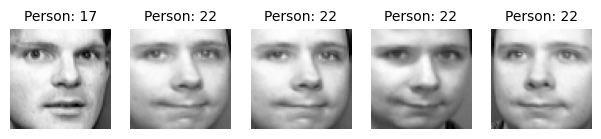


--- Detailed Analysis of Person 22's Clusters ---

Visualizing content of Cluster 1 (containing Person 22):


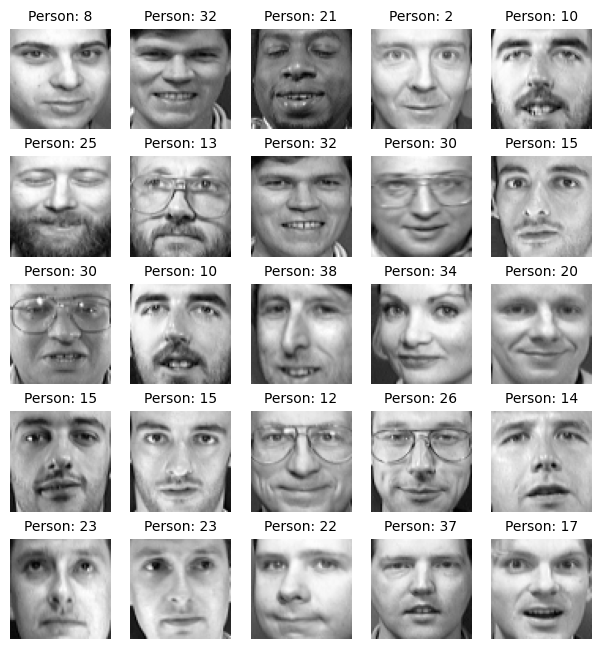

 -> People in Cluster 1: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25
 26 27 28 29 30 31 32 34 35 36 37 38]

Visualizing content of Cluster 7 (containing Person 22):


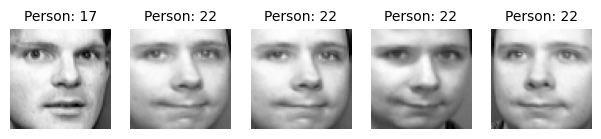

 -> People in Cluster 7: [17 22]

Visualizing content of Cluster 21 (containing Person 22):


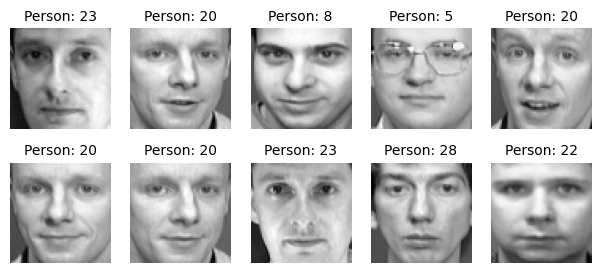

 -> People in Cluster 21: [ 5  8 20 22 23 28]

Visualizing content of Cluster 40 (containing Person 22):


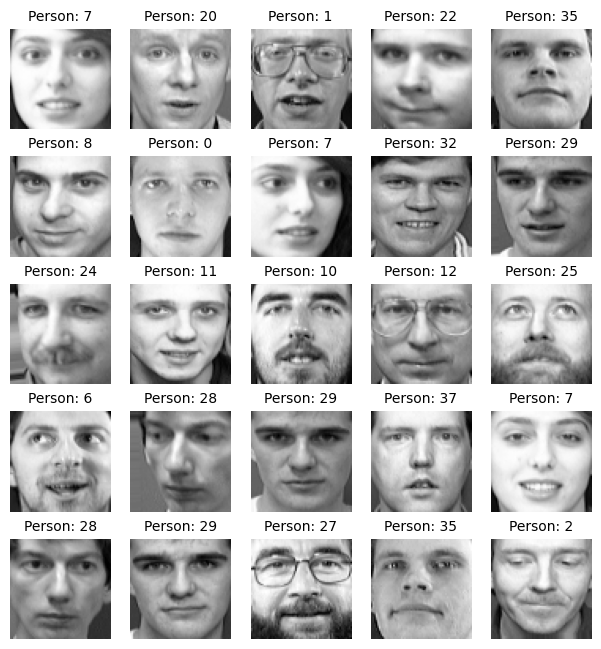

 -> People in Cluster 40: [ 0  1  2  4  5  6  7  8 10 11 12 13 15 19 20 22 23 24 25 26 27 28 29 30
 32 34 35 36 37 39]

--- General Vision: New Cluster Centroids (PCA-Optimized) ---
Note: These centroids are reconstructed from PCA space back to Pixel space.


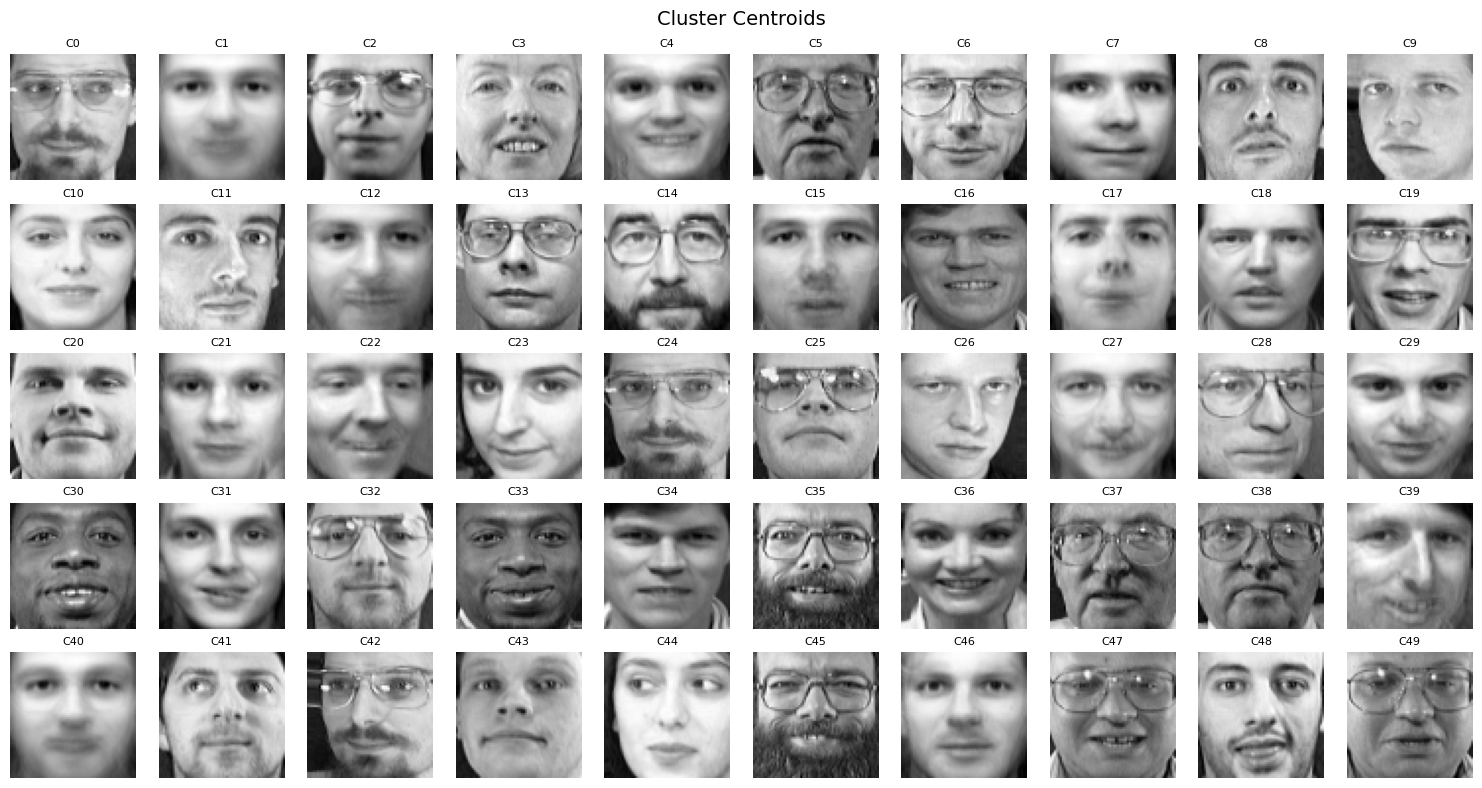

In [11]:
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt


print("--- Step 6: Optimization with PCA ---")

# 1. Setup the PCA to retain 99% of variance
# 'whiten=True' normalizes the data, which often helps K-Means
pca = PCA(n_components=0.99, whiten=True, random_state=42)

# 2. Transform the training data
X_train_pca = pca.fit_transform(X_train)

print(f"Original feature count: {X_train.shape[1]} pixels")
print(f"Reduced feature count:  {X_train_pca.shape[1]} components")
print(f"Reduction ratio: {X_train.shape[1] / X_train_pca.shape[1]:.1f}x smaller")

# 3. Retrain K-Means on the reduced data
# We use the same best_k we found earlier to make a fair comparison
print(f"\nRetraining K-Means on PCA data (k={best_k})...")
kmeans_pca = KMeans(n_clusters=best_k, **model_params)
kmeans_pca.fit(X_train_pca)

# --- 4. Verification: Checking Cluster Purity Again ---

# Let's find where 'Person 22' ended up in this new model
# We find all indices where the true label is 22
p22_indices = np.where(y_train == 22)[0]

# We predict the clusters for these specific images
p22_new_clusters = kmeans_pca.predict(X_train_pca[p22_indices])

print(f"\n--- Improvement Check ---")
print(f"Indices of Person 22: {p22_indices}")
print(f"Assigned Clusters (New Model): {p22_new_clusters}")

# Check if they are all in the same cluster now
unique_clusters = np.unique(p22_new_clusters)
if len(unique_clusters) == 1:
    print(f"SUCCESS: All images of Person 22 are now in a single cluster (Cluster {unique_clusters[0]}).")
else:
    print(f"Result: Split across {len(unique_clusters)} clusters: {unique_clusters}")

# Visualize the main cluster for Person 22 to see if intruders are gone
main_cluster_id = mode(p22_new_clusters, keepdims=True).mode[0]
print(f"\nVisualizing the content of the new Cluster {main_cluster_id}...")

indices_new = np.where(kmeans_pca.labels_ == main_cluster_id)[0]
plot_faces(X_train[indices_new], y_train[indices_new], n_cols=min(5, len(indices_new)))

# --- 5. detailed Inspection of Person 22's Split ---

print("\n--- Detailed Analysis of Person 22's Clusters ---")
# Get the unique clusters where Person 22 was assigned
# Based on your previous output, these should be [1, 7, 21, 40]
unique_clusters_p22 = np.unique(p22_new_clusters)

for cluster_id in unique_clusters_p22:
    print(f"\nVisualizing content of Cluster {cluster_id} (containing Person 22):")
    
    # Find all images in the entire dataset assigned to this cluster
    indices_in_cluster = np.where(kmeans_pca.labels_ == cluster_id)[0]
    images_in_cluster = X_train[indices_in_cluster]
    labels_in_cluster = y_train[indices_in_cluster]
    
    # Plot them to see why they were grouped together
    # We limit to 10 images per cluster to keep the report clean
    plot_faces(images_in_cluster[:25], labels_in_cluster[:25], n_cols=5)
    
    # Check purity of this specific cluster
    people_in_cluster = np.unique(labels_in_cluster)
    print(f" -> People in Cluster {cluster_id}: {people_in_cluster}")


# --- 6. General Vision: Visualizing the New PCA Centroids ---

print("\n--- General Vision: New Cluster Centroids (PCA-Optimized) ---")
print("Note: These centroids are reconstructed from PCA space back to Pixel space.")

# 1. We need to transform the centroids from PCA space (e.g., 220 dims) back to 4096 dims
centroids_pca = kmeans_pca.cluster_centers_
centroids_restored = pca.inverse_transform(centroids_pca)

# 2. Plot the first 50 centroids (similar to your uploaded image)
# These represent the 'cleaner' average faces learned by the model
plot_centroids(centroids_restored, n_cols=10, n_rows=5)


--- Visualizing the Optimized Cluster Space ---


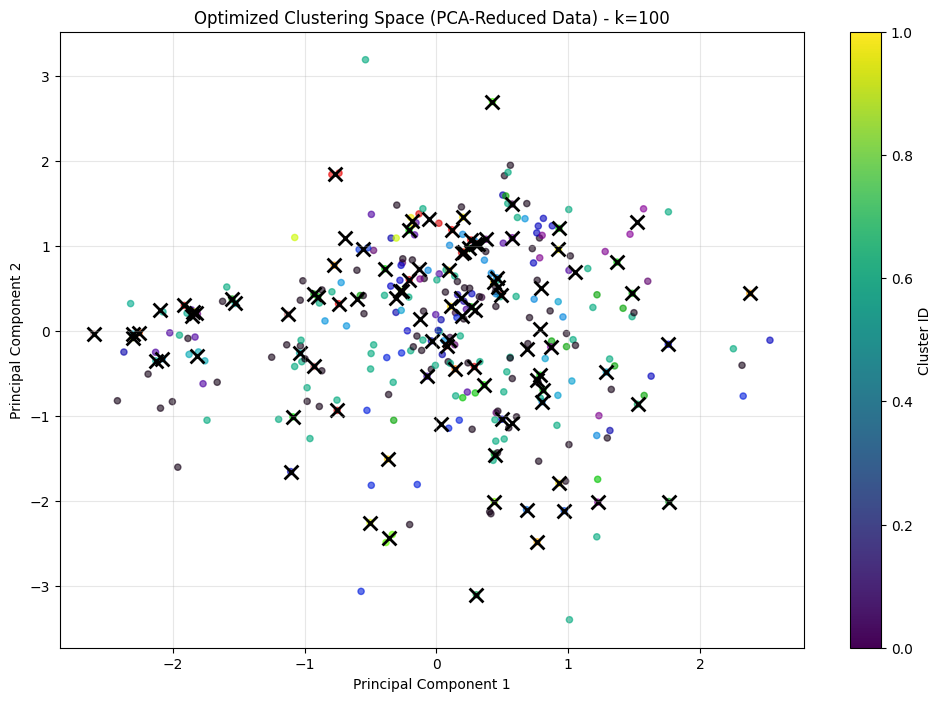


--- Visualizing the Optimized Cluster Space (Matplotlib 3D) ---


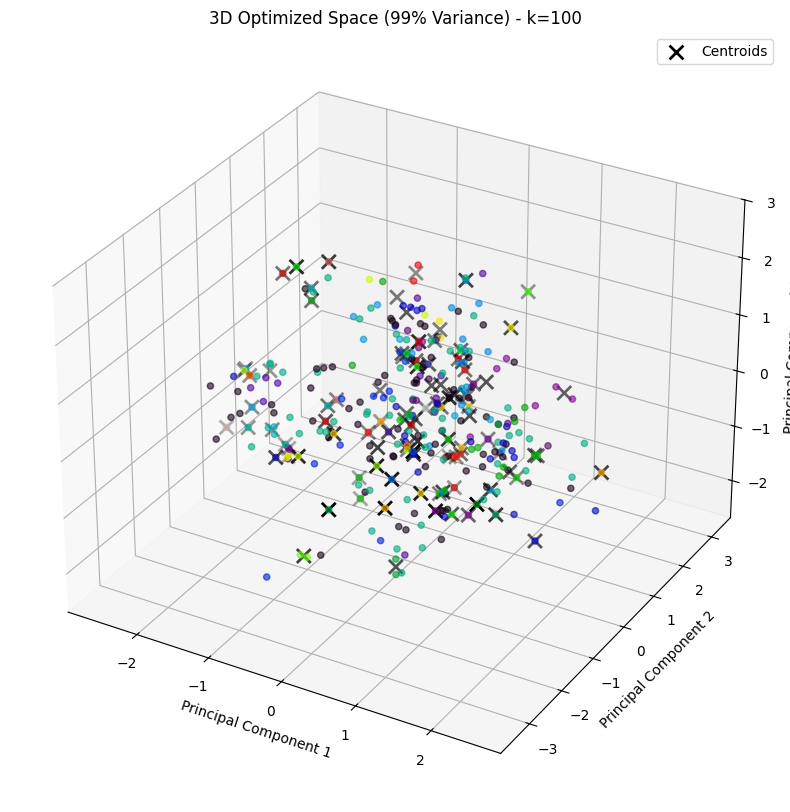

In [12]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import numpy as np

print("\n--- Visualizing the Optimized Cluster Space ---")

# Tomamos las etiquetas del NUEVO modelo
labels_optim = kmeans_pca.labels_
centroids_optim = kmeans_pca.cluster_centers_

# --- Opción A: Gráfica 2D Estática (Matplotlib) ---
plt.figure(figsize=(12, 8))

# Ploteamos los puntos (Usamos columna 0 y 1 de X_train_pca)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
            c=labels_optim, cmap='nipy_spectral', s=20, alpha=0.6)

# Ploteamos los centroides (Usamos columna 0 y 1 de los centroides del modelo)
plt.scatter(centroids_optim[:, 0], centroids_optim[:, 1], 
            marker='x', s=100, linewidths=2, color='black', label='Centroids')

plt.title(f"Optimized Clustering Space (PCA-Reduced Data) - k={best_k}")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster ID')
plt.grid(True, alpha=0.3)
plt.show()



import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

print("\n--- Visualizing the Optimized Cluster Space (Matplotlib 3D) ---")

# Etiquetas y centroides del modelo optimizado
labels_optim = kmeans_pca.labels_
centroids_optim = kmeans_pca.cluster_centers_

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 1. Ploteamos los puntos (Caras)
# Usamos las 3 primeras columnas de X_train_pca (PC1, PC2, PC3)
scatter = ax.scatter(X_train_pca[:, 0], 
                     X_train_pca[:, 1], 
                     X_train_pca[:, 2], 
                     c=labels_optim, 
                     cmap='nipy_spectral', 
                     s=20, 
                     alpha=0.6)

# 2. Ploteamos los centroides
ax.scatter(centroids_optim[:, 0], 
           centroids_optim[:, 1], 
           centroids_optim[:, 2], 
           marker='x', 
           s=100, 
           linewidths=2, 
           color='black', 
           label='Centroids')

ax.set_title(f"3D Optimized Space (99% Variance) - k={best_k}")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.legend()
plt.show()

# 7. Final Observations

**Analysis of PCA-Optimized Clustering**

A visual examination of the clusters produced after applying PCA reveals three distinct behaviors of the model:

* **High-Purity Clusters (e.g., Cluster 7):** The model successfully formed a dominant cluster for *Person 22*, containing four of their images and only one visually similar outlier (*Person 17*). This indicates that PCA effectively emphasized key structural characteristics—such as jawline shape and lighting patterns—needed to capture the core identity of the subject.

* **Generic “Catch-All” Clusters (e.g., Clusters 1 and 40):** Very large clusters were observed that include images from nearly every individual in the dataset. These clusters function as repositories for faces lacking strong distinguishing features, such as glasses, beards, or unique lighting conditions. Images of *Person 22* assigned to these clusters were likely those with the most neutral poses, making them mathematically closer to the global mean than to a person-specific cluster.

* **Smooth Centroids:** The centroids reconstructed from PCA space appear noticeably smoother and less noisy compared to those derived from raw pixel data. This confirms that PCA effectively removed high-frequency background noise, enabling K-Means to concentrate on meaningful facial structure rather than irrelevant details.

**Project Conclusion:**
This project shows that while K-Means is effective at uncovering patterns, it does not naturally align with semantic categories such as human identity when applied directly to raw data.

* **Without PCA:** The model is highly sensitive to pixel-level noise.
* **With PCA:** The clustering quality improves visually, producing cleaner features and purer clusters for distinctive poses. However, the algorithm still struggles with faces that appear more “average,” grouping them into large, mixed clusters.

Overall, this highlights a key trade-off in unsupervised learning: it excels at revealing structure and extracting features, but lacks the precision and label alignment of supervised classification methods.
